##Importing the libraries

In [32]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

##Loading the dataset

In [100]:
path = kagglehub.dataset_download("yufengdev/bbc-fulltext-and-category")

Using Colab cache for faster access to the 'bbc-fulltext-and-category' dataset.


In [101]:
print("Files:", os.listdir(path))

Files: ['bbc-text.csv']


In [102]:
#Loading the dataset
file_path = os.path.join(path, "bbc-text.csv")
df = pd.read_csv(file_path)

print(df.head())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


In [103]:
print("Dataset shape before filtering:", df.shape)
print(df['category'].value_counts())

Dataset shape before filtering: (2225, 2)
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


Text(0.5, 1.0, 'Label Distribution')

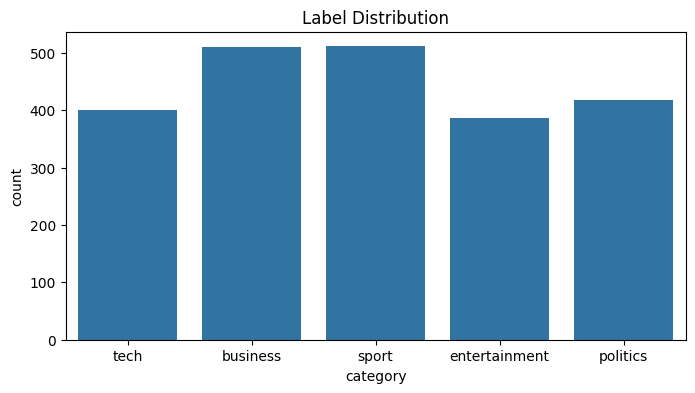

In [104]:
#Distribution of different labels
plt.figure(figsize=(8,4))
sns.countplot(x='category', data=df)
plt.title("Label Distribution")

In [105]:
#Filtering only sport and politics
df = df[df['category'].isin(['sport', 'politics'])]
#Rename the columns
df = df.rename(columns={"content": "text", "category": "label"})

print("Dataset shape after filtering:", df.shape)
print(df['label'].value_counts())
print()
df.info()

Dataset shape after filtering: (928, 2)
label
sport       511
politics    417
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 928 entries, 2 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   928 non-null    object
 1   text    928 non-null    object
dtypes: object(2)
memory usage: 21.8+ KB


Text(0.5, 1.0, 'Label Distribution')

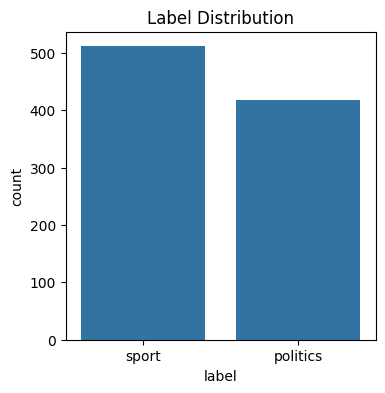

In [106]:
#Distribution of different labels post filtering
plt.figure(figsize=(4,4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution")

##Feature representaion

In [107]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
# nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

#Data preprocessing
df["clean_text"] = df["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
X = df["clean_text"]
y = df["label"]

#Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=30, stratify=y)

#Feature representation
vectorizers = {
    "BoW": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
    "TF-IDF + Bigrams": TfidfVectorizer(ngram_range=(1,2))}

#ML techniques for the task
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC()}

##Training the models

In [109]:
results = []
for vec_name, vectorizer in vectorizers.items():

    print(f"\nUsing Feature: {vec_name}")

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():

        print(f"Training Model: {model_name}")

        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        acc = accuracy_score(y_test, y_pred)
        results.append((vec_name, model_name, acc))

        print(classification_report(y_test, y_pred))

print("\nTraining Completed.")


Using Feature: BoW
Training Model: Naive Bayes
              precision    recall  f1-score   support

    politics       1.00      1.00      1.00        84
       sport       1.00      1.00      1.00       102

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

Training Model: Logistic Regression
              precision    recall  f1-score   support

    politics       1.00      0.98      0.99        84
       sport       0.98      1.00      0.99       102

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186

Training Model: SVM
              precision    recall  f1-score   support

    politics       1.00      0.99      0.99        84
       sport       0.99      1.00      1.00       102

    accuracy                           0.99       186
   macro avg       1.00 

In [110]:
#Saving the results
os.makedirs("results", exist_ok=True)
results_df = pd.DataFrame(results, columns=["Features", "Model", "Accuracy"])
results_df.to_csv("results/model_results.csv", index=False)

##Comparison of the techniques

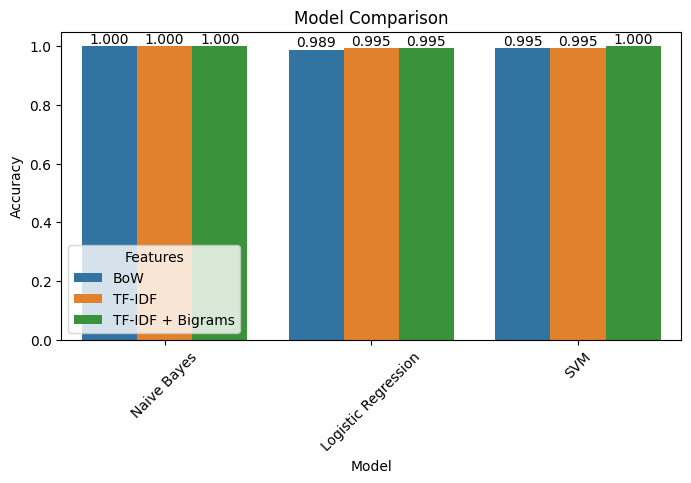

In [112]:
results = pd.read_csv("results/model_results.csv")

#Comparison of the techniques
plt.figure(figsize=(8,4))
ax = sns.barplot(data=results, x="Model", y="Accuracy", hue="Features")
plt.title("Model Comparison")
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')

plt.savefig("results/accuracy_comparison.png")